# Sound Classification

## Introduction

Ever wondered how a Machine Learning algorithm identifies and classifies a sound? In this session, I'll start with the basics of sound, followed by its working using Machine Learning. We'll explore the sound dataset, perform analysis on it and build a multi class sound classifier using pytorch.

## Basics of sound

- Frequency
- Amplitude
- Sample Size
- Channels : Mono or Stereo- 
- Different formats of file (wav, mpeg)
- Spectrogram
- Mel-Spectrogram


## Internal of Sound Classification

TODO: Explain sound classification

## Exploratory Data Analysis

### Dataset

Name: GTZAN Dataset - Music Genre Classification
Source: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

Dataset contains
- genres original folder
- images original folder
- features30seconds.csv file
- features3seconds.csv file

### Install Dependencies

In [1]:
!python --version

Python 3.10.4


In [21]:
!pip install -r requirements.txt

  Using cached numpy-1.21.5-cp310-cp310-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


In [3]:
import sys
print(sys.path)
print(sys.executable)

['D:\\Praveen\\sourcecontrol\\github\\praveenraghuvanshi\\sound-classification\\python\\src', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310', '', 'C:\\Users\\praghuvanshi\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib', 'C:\\Users\\praghuvanshi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin']
C:\Users\praghuvanshi\AppData\Local\Programs\Python\Python310\python.exe


### Import Packages

In [29]:
# Data Analysis
import numpy as np
import pandas as pd              # loading dataset
import matplotlib.pyplot as plt  # plotting library
import opendatasets as od        # download kaggle dataset

# I/O
import os                        # OS related commands such as listing of directory

# Deep Neural Network and Audio processing
import torch
import torchaudio                 # accessing and processing audio 
import torchaudio.transforms as T # Audio transformation
import librosa                    # audio processing

In [6]:
audio_backend = torchaudio.get_audio_backend()

if audio_backend == None:
    !pip install PySoundFile
    torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
    torchaudio.set_audio_backend("soundfile")
    
print(torchaudio.get_audio_backend())

soundfile


### Define CONSTANTS and Variables

In [7]:
CURRENT_WORKING_DIRECTORY = os.getcwd()
DATASET_PATH = os.path.join(CURRENT_WORKING_DIRECTORY, 'gtzan-dataset-music-genre-classification', 'Data')
JAZZ_DIRECTORY_PATH = os.path.join(DATASET_PATH, 'genres_original', 'jazz')
SAMPLE_AUDIO_FILE_PATH = os.path.join(JAZZ_DIRECTORY_PATH, 'jazz.00002.wav')

FEATURES_30_SECONDS_PATH = os.path.join(DATASET_PATH, 'features_30_sec.csv')

print(SAMPLE_AUDIO_FILE_PATH)

D:\Praveen\sourcecontrol\github\praveenraghuvanshi\sound-classification\python\src\gtzan-dataset-music-genre-classification\Data\genres_original\jazz\jazz.00002.wav


### Utility Functions

#### Plot Waveform

In [8]:
### Plots waveform of an audio file
### source: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

#### Plot Spectrogram

In [9]:
### Plot Spectrogram
### source: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

### Download Dataset

In [10]:
if os.path.isdir(DATASET_PATH) :
 print("Directory  exists")
else:
 print("Directory not exists")
 od.download("https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification")

Directory  exists


In [11]:
print(os.getcwd())
print(os.listdir())

D:\Praveen\sourcecontrol\github\praveenraghuvanshi\sound-classification\python\src
['.ipynb_checkpoints', 'features_30_sec.csv', 'gtzan-dataset-music-genre-classification', 'requirements.txt', 'Sound-Classification.ipynb']


### Analysis

We will load 'features_3_sec.csv' into dataframe for analysis

In [12]:
import pandas as pd

audio_df = pd.read_csv(FEATURES_30_SECONDS_PATH, header=0)

In [13]:
audio_df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [14]:
audio_df.tail()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock
999,rock.00099.wav,661794,0.358401,0.085884,0.054454,0.000336,1609.795082,422203.216152,1797.213044,120115.632927,...,59.167755,-7.069775,73.760391,0.028346,76.504326,-2.025783,72.189316,1.155239,49.662510,rock


In [15]:
audio_df.shape

(1000, 60)

In [16]:
audio_modified_df = audio_df[['filename', 'length', 'label']]
print(audio_modified_df)

            filename  length  label
0    blues.00000.wav  661794  blues
1    blues.00001.wav  661794  blues
2    blues.00002.wav  661794  blues
3    blues.00003.wav  661794  blues
4    blues.00004.wav  661794  blues
..               ...     ...    ...
995   rock.00095.wav  661794   rock
996   rock.00096.wav  661794   rock
997   rock.00097.wav  661794   rock
998   rock.00098.wav  661794   rock
999   rock.00099.wav  661794   rock

[1000 rows x 3 columns]


In [17]:
audio_modified_df.label.value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

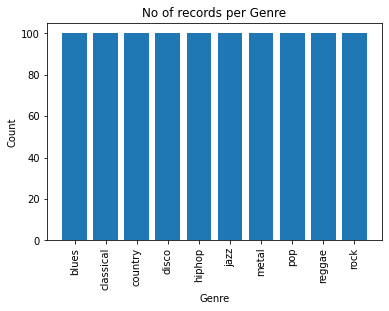

In [18]:
labels = audio_modified_df.label.unique()
data = audio_modified_df.label.value_counts()
plt.xticks(range(len(data)), labels,rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('No of records per Genre')
plt.bar(range(len(data)), data) 
plt.show()

### Analyze Audio Data

#### Metadata

In [19]:
metadata = torchaudio.info(SAMPLE_AUDIO_FILE_PATH)
filesizeinbytes = os.path.getsize(SAMPLE_AUDIO_FILE_PATH)
filesizeinkb = filesizeinbytes / 1024

print("************ AUDIO METADATA ***************")
print()
print("Sample Rate              :", metadata.sample_rate)
print("Number of Frames/Channel :", metadata.num_frames)
print("Number of Channels       :", metadata.num_channels)
print("Bits Depth               :", metadata.bits_per_sample)
print("Encoding Format          :", metadata.encoding)
print(f"File size               : {filesizeinbytes} bytes / {filesizeinkb:.2f} kb")
print()
print("******************************************")

************ AUDIO METADATA ***************

Sample Rate              : 22050
Number of Frames/Channel : 661794
Number of Channels       : 1
Bits Depth               : 16
Encoding Format          : PCM_S
File size               : 1323632 bytes / 1292.61 kb

******************************************


#### Waveform

In [34]:
waveform, sample_rate = torchaudio.load(SAMPLE_AUDIO_FILE_PATH)

RuntimeError: Numpy is not available

In [35]:
plot_waveform(waveform, sample_rate)

NameError: name 'waveform' is not defined

#### Spectrogram

In [ ]:
plot_spectrogram(waveform, title='Spectrogram')

#### Mel-Spectrogram

In [36]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

NameError: name 'sample_rate' is not defined

### Visualize images

## Machine learning

In [ ]:
# Load Dataset from Kaggle
# Split dataset into train and val
# Transform audio files to image
# Perform image analysis using ANN
# Perform image analysis using CNN
# Perform image analysis using transfer learning(Resnet-50)
# Validate on test dataset : Display metrics
# Evaluate sample offset on best model